<H1 style="text-align: center">EEEM068 - Applied Machine Learning</H1>
<H1 style="text-align: center">Human Action Recognition - ViT</H1>

In [1]:
import os
#Download and Extract the dataset if it doesn't not exists
dataset_path = 'dataset\HMDB_simp'

if not os.path.exists(dataset_path):
    if not os.path.exists('HMDB_simp.zip'):
        !wget https://zenodo.org/record/7718549/files/HMDB_simp.zip
    import zipfile
    with zipfile.ZipFile('HMDB_simp.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset/')

In [2]:
%%capture
%pip install -r requirements.txt

In [3]:
import torch
import pickle
import numpy as np
from PIL import Image
from tqdm import tqdm
from datetime import datetime

from src.dataset.hmdb_simp import HMDBDataset, load_video_label_mapping
from src.utils.train_test_split import TrainTestSplit
from src.model.timesformer import Timesformer
from src.utils.trainer import Trainer

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device

'cuda'

In [4]:
hmdb_dataset_path = "dataset/HMDB_simp/"

videos_paths, labels, labels_ref = load_video_label_mapping(hmdb_dataset_path)

100%|██████████| 25/25 [00:00<00:00, 4998.46it/s]


In [5]:
RANDOM_STATE = 32
DISTRIBUTED_SPLIT = True

train_video_paths, test_video_paths, train_labels, test_labels = TrainTestSplit.split(
    videos_paths, labels, RANDOM_STATE, DISTRIBUTED_SPLIT, test_size=0.2)


# TimeSformer K400

In [6]:
learning_rate = 0.001
batch_size = 3
num_epoch = 8

model_file = f"checkpoints/train-CLF-DT-RS{RANDOM_STATE}-B{batch_size}-L{learning_rate}-E{num_epoch}-{datetime.now().microsecond}.model"
# model_file = "checkpoints/train-CLF-RS15-B8-L0.001-E4-469251.model"

if os.path.exists(model_file):
    model = torch.load(model_file)
else:
    model = Timesformer(n_classes=len(labels_ref), device=device)

train_set, test_set = (HMDBDataset(videos_paths=train_video_paths, labels=train_labels), HMDBDataset(videos_paths=test_video_paths, labels=test_labels))
    
model.to(device)

trainer = Trainer(model=model, batch_size=batch_size, device=device, learning_rate=learning_rate,test_set=test_set, train_set=train_set, classes = labels_ref)

In [10]:
# num_epoch = 8
for epoch in range(num_epoch):
    print(f"Epoch: {epoch}/{num_epoch};")
    trainer.train()

Epoch: 0/8;


Training:   0%|          | 0/334 [00:00<?, ?frames/s]

Train: Average loss: 0.01356782

Epoch: 1/8;


Training:   0%|          | 0/334 [00:00<?, ?frames/s]

Train: Average loss: 0.01065544

Epoch: 2/8;


Training:   0%|          | 0/334 [00:00<?, ?frames/s]

Train: Average loss: 0.00843636

Epoch: 3/8;


Training:   0%|          | 0/334 [00:00<?, ?frames/s]

Train: Average loss: 0.00685887

Epoch: 4/8;


Training:   0%|          | 0/334 [00:00<?, ?frames/s]

Train: Average loss: 0.00873958

Epoch: 5/8;


Training:   0%|          | 0/334 [00:00<?, ?frames/s]

Train: Average loss: 0.00480956

Epoch: 6/8;


Training:   0%|          | 0/334 [00:00<?, ?frames/s]

Train: Average loss: 0.00488053

Epoch: 7/8;


Training:   0%|          | 0/334 [00:00<?, ?frames/s]

Train: Average loss: 0.00346084



In [11]:
torch.save(model, model_file)

Test:   0%|          | 0/84 [00:00<?, ?frames/s]

Test: Average loss: 0.4732, Accuracy: 213/250 (85.20%)

              precision    recall  f1-score   support

  brush_hair       0.82      0.90      0.86        10
   cartwheel       0.58      0.70      0.64        10
       catch       1.00      1.00      1.00        10
        chew       0.90      0.90      0.90        10
       climb       1.00      0.90      0.95        10
climb_stairs       0.83      1.00      0.91        10
  draw_sword       0.78      0.70      0.74        10
         eat       0.58      0.70      0.64        10
     fencing       1.00      0.90      0.95        10
   flic_flac       0.80      0.80      0.80        10
        golf       1.00      1.00      1.00        10
   handstand       0.62      0.80      0.70        10
        kiss       0.82      0.90      0.86        10
        pick       0.60      0.60      0.60        10
        pour       1.00      1.00      1.00        10
      pullup       1.00      1.00      1.00        10
      pushup       1.00  

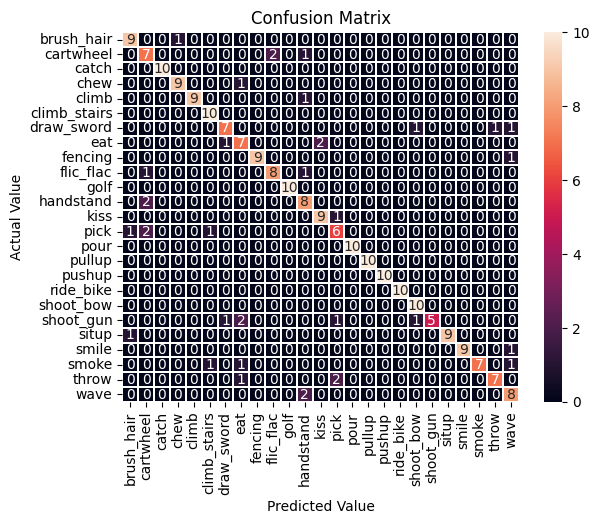

<Figure size 900x700 with 0 Axes>

Top 1 Accuracy: 85.20%
Top 5 Accuracy: 100.00%


In [12]:
trainer.test()

In [13]:
from src.utils.attention_map_visualizer import plot_attention
def get_index_of_action(data_set,action, defer=1):
    target_index = labels_ref.index(action)
    defer_count = 0
    for idx, data in enumerate(data_set):
        video, label_index = data
        if label_index == target_index:
            defer_count+=1
            if defer_count == defer:
                return idx

c:\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


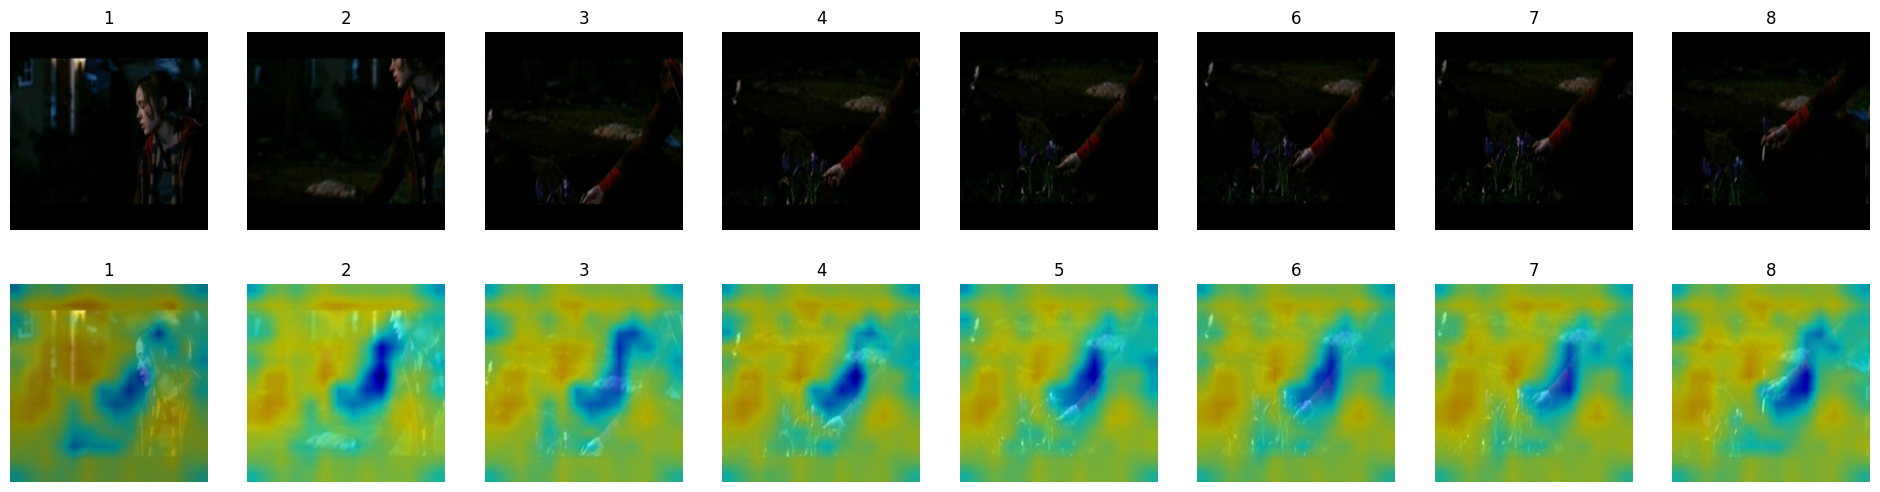

In [14]:
plot_attention(model.cpu(), test_set[get_index_of_action(test_set, 'pick', defer=2)][0])

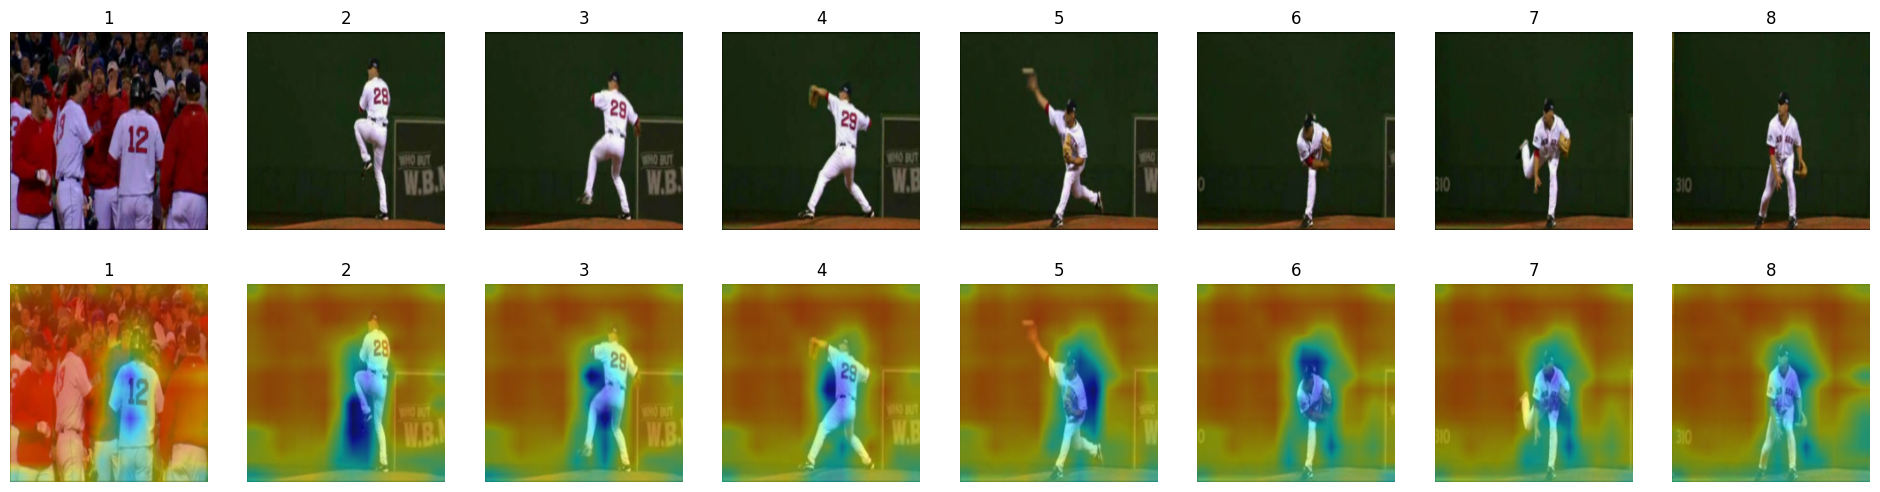

In [15]:
plot_attention(model, test_set[get_index_of_action(test_set, 'throw', defer=2)][0])

# TimeSformer-HR

In [16]:
learning_rate = 0.001
batch_size = 8
num_epoch = 4

model_file_16f = f"checkpoints/train-timeSHR-CLF-RS{RANDOM_STATE}-B{batch_size}-L{learning_rate}-E{num_epoch}-{datetime.now().microsecond}.model"
# model_file = "train-CLF-B8-L0.001-E8-133427.model"

if os.path.exists(model_file_16f):
    model_hr = torch.load(model_file_16f)
else:
    model_hr = Timesformer(n_classes=len(
        labels_ref), device=device, model_path="facebook/timesformer-hr-finetuned-k400")
model_hr.to(device)

train_set_16f, test_set_16f = (HMDBDataset(videos_paths=train_video_paths, labels=train_labels, numberOfFrames=16, imageSize=448),
                       HMDBDataset(videos_paths=test_video_paths, labels=test_labels, numberOfFrames=16, imageSize=448))

trainer_16f = Trainer(model=model_hr,
                  batch_size=batch_size,
                  device=device,
                  learning_rate=learning_rate,
                  test_set=test_set_16f,
                  train_set=train_set_16f,
                  classes=labels_ref)


In [ ]:
for epoch in range(num_epoch):
    print(f"Epoch: {epoch}/{num_epoch};")
    trainer_16f.train()

In [ ]:
torch.save(model_hr,model_file_16f)

In [ ]:
trainer_16f.test()